<a href="https://colab.research.google.com/github/jon-chun/https://github.com/jon-chun/sentimentarcs_simplified/sentimentarcs_supersimplified_20241121.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>


# SentimentArcs Simplified Notebook
## ***(Version 20241115.v1)***

## ***Use GPU for Transformer Models***

* 28 Oct 2022: Created
* 12 Nov 2024: Last Major Update
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

In [1]:
%whos

# CHECK program space for imported and defined objects

Interactive namespace is empty.


In [2]:
# TEST: To avoid later permission pop-up interruption

import os
from google.colab import userdata

hf_key = userdata.get('HF_TOKEN')

if hf_key is None:
  print("HF_KEY not found in secrets")
else:
  os.environ['HF_KEY'] = hf_key
  print("HF_KEY found and set")


HF_KEY found and set


In [3]:
# TEST: To avoid later permission pop-up interruption

with open('test.txt', 'w') as f:
  f.write("test content")

from google.colab import files
files.download('test.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PRE-REQUISITES**

## INPUT Text File
- name: format 'book_{title-words}_{author}.txt'
-- eg book_animal-farm_gorwell.txt
-- eg book_the-great-gatsby_fscottfitzgerald.txt
- content: cleaned plain text

## API Keys Necessary
- huggingface.co ('HF_TOKEN')
- wandb.com ('WANDB_TOKEN')



# Setup

## Install Libraries

In [4]:
# !pip install transformers[sentencepiece]

!pip install transformers

In [5]:
# Installed by default in Colab

# !pip install nltk

In [6]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
# !pip install -U spacy

In [8]:
# !python -m spacy download en_core_web_sm

In [9]:
# !pip install pysbd  # Python Sentence Boundry Detection

In [10]:
# Installed by default in Colab

# !pip install TextBlob

In [11]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.3 MB/s eta 0:00:00


In [12]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [13]:
from google.colab import files

In [14]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from scipy.signal import find_peaks, argrelextrema
from statsmodels.nonparametric.smoothers_lowess import lowess
import textwrap

import time
import datetime
import re
import os

import chardet  # Library for detecting encoding

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

In [15]:
# import pysbd

In [16]:
# import spacy

## Configure Settings

In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [18]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [19]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [20]:
def save_text2txt_and_download(text_obj, filename_base='BOOK_FILENAME_BASE', file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  # out_filename = novel_name_str.split('.')[0] + file_suffix
  out_filename = filename_base + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [21]:
def save_plot2png(file_suffix='_plot.png', nodate=True, base_filename='plot'):
    '''
    Save the current plot to a PNG file.

    INPUT:
    - file_suffix: The suffix to add to the output PNG filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "plot" if unspecified).

    OUTPUT:
    - Saves the current plot to a PNG file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the plot
    plt.savefig(out_filename)
    print(f'STEP 1. Saving plot to temporary VM file: {out_filename}\n')

    # Download the saved file
    print(f'STEP 2. Downloading permanent copy of the PNG file: {out_filename}\n')
    files.download(out_filename)

In [22]:
def save_df2csv_and_download(df, file_suffix='_data.csv', nodate=True, base_filename='data'):
    '''
    Save the DataFrame to a CSV file.

    INPUT:
    - df: The DataFrame to save.
    - file_suffix: The suffix to add to the output CSV filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "data" if unspecified).

    OUTPUT:
    - Saves the DataFrame to a CSV file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the DataFrame to CSV
    df.to_csv(out_filename, index=False)
    print(f'STEP 1. Saving DataFrame to temporary VM CSV file: {out_filename}\n')

    # Download the saved CSV file
    print(f'STEP 2. Downloading permanent copy of the CSV file: {out_filename}\n')
    files.download(out_filename)

# Get Clean Text

### **[STOP to INPUT]** Upload Trimmed Gutenberg Text (no header/footer)

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [23]:
# PART 1: Upload Plain Text File

novel_name_str = ''
uploaded = files.upload()

# Allows for multiple file uploads, will only process the last
# Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes.')
    novel_name_str = fn

# Extract from Dict and detect encoding
raw_data = uploaded[novel_name_str]  # Access the uploaded file's raw binary data

# Step 1: Detect the encoding
encoding_info = chardet.detect(raw_data)
detected_encoding = encoding_info['encoding']
print(f"Detected file encoding: {detected_encoding}")

# Step 2: Attempt decoding with detected encoding
try:
    novel_raw_str = raw_data.decode(detected_encoding)
except (UnicodeDecodeError, TypeError):
    print(f"Failed to decode using detected encoding: {detected_encoding}. Attempting fallback.")

    # Step 3: Fallback to a common encoding
    try:
        novel_raw_str = raw_data.decode('utf-8')
        print("Successfully decoded using utf-8 as fallback.")
    except UnicodeDecodeError:
        try:
            novel_raw_str = raw_data.decode('latin1')  # Latin1 as a last resort
            print("Successfully decoded using latin1 as fallback.")
        except UnicodeDecodeError as e:
            print(f"Critical error: Unable to decode file. Error: {e}")
            raise

# If decoding succeeded, proceed with further processing
print(f"First 500 characters of the decoded text:\n{novel_raw_str[:500]}")


Saving book_odyssey_homer.txt to book_odyssey_homer.txt
User uploaded file "book_odyssey_homer.txt" with length 639541 bytes.
Detected file encoding: utf-8
First 500 characters of the decoded text:
Tell me, Muse, of that man, so ready at need, who wandered far and
wide, after he had sacked the sacred citadel of Troy, and many were the
men whose towns he saw and whose mind he learnt, yea, and many the woes
he suffered in his heart on the deep, striving to win his own life and
the return of his company. Nay, but even so he saved not his company,
though he desired it sore. For through the blindness of their own
hearts they perished, fools, who devoured the oxen of Helios Hyperion:
but 


In [24]:
# PART 2: Verify Upload Text

verify_novel(novel_raw_str)

Novel Name: book_odyssey_homer.txt
  Char Len: 633697

Beginning:

 Tell me, Muse, of that man, so ready at need, who wandered far and
wide, after he had sacked the sacred citadel of Troy, and many were the
men whose towns he saw and whose mind he learnt, yea, and many the woes
he suffered in his heart on the deep, striving to win his own life and
the return of his company. Nay, but even so he saved not his company,
though he desired it sore. For through the blindness of their own
hearts they perished, fools, who devoured the oxen of Helios Hyperion:
but 



------------------------------------
Ending:

 heir lives. But
Ulysses gave a great cry, and gathering himself together swooped down
like a soaring eagle. Then the son of Saturn sent a thunderbolt of fire
that fell just in front of Minerva, so she said to Ulysses, “Ulysses,
noble son of Laertes, stop this warful strife, or Jove will be angry
with you.”

Thus spoke Minerva, and Ulysses obeyed her gladly. Then Minerva assumed
the for

In [25]:
# PART 3: Verify FILENAME variants based upon uploaded filename

BOOK_FILENAME_AUTHOR_CLEAN = novel_name_str.split('.')[0]
print(f"BOOK_FILENAME_AUTHOR_CLEAN: {BOOK_FILENAME_AUTHOR_CLEAN}")

print('\n')

# prompt: set book_filename_author_clean = a cleaned version of BOOK_FILENAME_AUTHOR that is 1. lowercased, 2. spaces replaced with '_' and 3. all punctuation except for dashes and underlines replaced with '-'
BOOK_TITLE_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.lower().replace(' ', '_').replace('[^a-zA-Z0-9_-]', '-')
print(f"BOOK_TITLE_AUTHOR_CLEAN: {BOOK_TITLE_AUTHOR_CLEAN}")

print('\n')

# prompt: set BOOK_TITLE_AUTHOR_TITLE = BOOK_TITLE_AUTHOR_CLEAN with '_' replaced by ' ' and the first letter of all words Capitalized
BOOK_TITLE_AUTHOR_TITLE = BOOK_TITLE_AUTHOR_CLEAN.replace('_', ' ').title()
print(f"BOOK_TITLE_AUTHOR_TITLE: {BOOK_TITLE_AUTHOR_TITLE}")

print('\n')

# prompt: change the leading string 'book_' with 'plot_' in the var BOOK_TITLE_AUTHOR_CLEAN

PLOT_FILENAME_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.replace('book_', 'plot_')
print(f"PLOT_FILENAME_AUTHOR_CLEAN: {PLOT_FILENAME_AUTHOR_CLEAN}")

print('\n')

# prompt: change the leading string 'book_' with 'data_' in the var BOOK_TITLE_AUTHOR_CLEAN

DATA_FILENAME_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.replace('book_', 'data_')
print(f"DATA_FILENAME_AUTHOR_CLEAN: {DATA_FILENAME_AUTHOR_CLEAN}")

BOOK_FILENAME_AUTHOR_CLEAN: book_odyssey_homer


BOOK_TITLE_AUTHOR_CLEAN: book_odyssey_homer


BOOK_TITLE_AUTHOR_TITLE: Book Odyssey Homer


PLOT_FILENAME_AUTHOR_CLEAN: plot_odyssey_homer


DATA_FILENAME_AUTHOR_CLEAN: data_odyssey_homer


## Clean Text

In [26]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=decc9ff98695010e1e6ac0a6d88b5ff0e0fe9112c1e0e8d8619e949b50cfa505
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [27]:
!pip install unidecode  # clean-text dependency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.4 MB/s eta 0:00:00


In [28]:
from cleantext import clean

In [29]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'tell me, muse, of that man, so ready at need, who wandered far and wide, after he had sacked the sacred citadel of troy, and many were the men whose towns he saw and whose mind he learnt, yea, and many the woes he suffered in his heart on the deep, striving to win his own life and the return of his company. nay, but even so he saved not his company, though he desired it sore. for through the blindness of their own hearts they perished, fools, who devoured the oxen of helios hyperion: but the god took from them their day of returning. of these things, goddess, daughter of zeus, whencesoever thou hast heard thereof, declare thou even unto us. now all the rest, as many as fled from sheer destruction, were at home, and had escaped both war and sea, but odysseus only, craving for his wife and for his homeward path, the lady nymph calypso held, that fair goddess, in her hollow caves, longing to have him for her lord. but when now the year had come in the courses of the seasons, wherein the 

In [30]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: book_odyssey_homer.txt
  Char Len: 621905

Beginning:

 tell me, muse, of that man, so ready at need, who wandered far and wide, after he had sacked the sacred citadel of troy, and many were the men whose towns he saw and whose mind he learnt, yea, and many the woes he suffered in his heart on the deep, striving to win his own life and the return of his company. nay, but even so he saved not his company, though he desired it sore. for through the blindness of their own hearts they perished, fools, who devoured the oxen of helios hyperion: but the god



------------------------------------
Ending:

 o the city for their lives. but ulysses gave a great cry, and gathering himself together swooped down like a soaring eagle. then the son of saturn sent a thunderbolt of fire that fell just in front of minerva, so she said to ulysses, "ulysses, noble son of laertes, stop this warful strife, or jove will be angry with you." thus spoke minerva, and ulysses obeyed her gladly. then m

## Trim Text

In [31]:
# FUTURE: Auto trim Gutenberg HEADER and FOOTER (varies too much)

novel_trim_str = novel_clean_str

## Segment Text

In [32]:
# FUTURE: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [33]:
'''

# FUTURE: Display Segmenting Progress Bar

from IPython.display import clear_output
import pysbd
import time  # Only for simulating delay in testing

# Set up the segmenter
seg = pysbd.Segmenter(language="en", clean=False)

# Segment novel with manual progress feedback
novel_segments_ls = []
total_segments = len(novel_trim_str.split('.'))  # Estimate segment count based on periods
update_every_n = 100  # Update output every 100 segments

# Start segmentation and manual progress display
for idx, segment in enumerate(seg.segment(novel_trim_str), start=1):
    novel_segments_ls.append(segment)

    # Periodically update the output
    if idx % update_every_n == 0 or idx == total_segments:
        clear_output(wait=True)
        print(f"Segmenting Novel: {idx}/{total_segments} segments processed")

print("Segmentation complete.")
''';

In [34]:
# CONFIGURE: Select segmentation method

SEGMENTATION_METHOD_LS = ['nltk','spacy','pysbd','wtpsplit']
SEGMENTATION_METHOD = SEGMENTATION_METHOD_LS[0]

print(f"Segmentation Method Selected: {SEGMENTATION_METHOD}")

Segmentation Method Selected: nltk


In [35]:
if SEGMENTATION_METHOD == 'nltk':
  # OPTION (A) Least precise sentence segmentation using NLTK (fast)

  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")
  def segment_sentences_nltk(text):
      sentences = sent_tokenize(text)
      return sentences

  novel_segments_ls = segment_sentences_nltk(novel_trim_str)
  # print(novel_segments_ls[:5])  # Preview the first few sentences
  # print(len(novel_segments_ls))

elif SEGMENTATION_METHOD == 'spacy':
  # OPTION (B) Mid-precision sentence segmentation using SpaCy (slow for large text)

  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")

  import spacy

  # Load the small English model in spaCy
  nlp = spacy.load("en_core_web_sm", disable=["tagger", "ner", "parser"])  # Disable unnecessary components for speed

  # Enable the sentence segmentation component only
  nlp.enable_pipe("senter")  # spaCy's rule-based sentence segmentation

  # Function to segment a large text
  def segment_sentences(text):
      # Process the text with spaCy
      doc = nlp(text)
      # Extract each sentence as a string
      sentences = [sent.text for sent in doc.sents]
      return sentences

  # Example usage
  novel_trim_str = """Your large text goes here..."""  # Replace with actual text
  sentences = segment_sentences(novel_trim_str)

  # Check the number of sentences and preview a few
  print(f"Total sentences: {len(sentences)}")
  print(sentences[:5])  # Preview first 5 sentences

elif SEGMENTATION_METHOD == 'pysbd':

  # OPTION (C) Most precise sentence segmentation using pysbd (very slow for large text, may crash)
  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")

  import pysbd

  seg = pysbd.Segmenter(language="en", clean=False)
  novel_segments_ls = [segment for segment in seg.segment(novel_trim_str)]

elif SEGMENTATION_METHOD == 'wtpsplit':

  # OPTION (D) Most upto date? (untested)
  # https://github.com/segment-any-text/wtpsplit

  print(f"SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")

  from wtpsplit import SaT

  sat_sm_adapted = SaT("sat-3l-sm", style_or_domain="ud", language="en")
  sat_sm_adapted.half().to("cuda") # optional, see above

  novel_segments_ls = [segment for segment in sat_sm_adapted(novel_trim_str)]

else:

  print(f"ERROR: Invalid SEGMENTATION_METHOD: {SEGMENTATION_METHOD}")


SEGMENTATION_METHOD: nltk


In [36]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [37]:
# First five lines
novel_clean_ls[:5]

print('\n')

# Last five line
novel_clean_ls[-5:]

['tell me, muse, of that man, so ready at need, who wandered far and wide, after he had sacked the sacred citadel of troy, and many were the men whose towns he saw and whose mind he learnt, yea, and many the woes he suffered in his heart on the deep, striving to win his own life and the return of his company.',
 'nay, but even so he saved not his company, though he desired it sore.',
 'for through the blindness of their own hearts they perished, fools, who devoured the oxen of helios hyperion: but the god took from them their day of returning.',
 'of these things, goddess, daughter of zeus, whencesoever thou hast heard thereof, declare thou even unto us.',
 'now all the rest, as many as fled from sheer destruction, were at home, and had escaped both war and sea, but odysseus only, craving for his wife and for his homeward path, the lady nymph calypso held, that fair goddess, in her hollow caves, longing to have him for her lord.']

["on this pale fear seized every one; they were so frightened that their arms dropped from their hands and fell upon the ground at the sound of the goddess' voice, and they fled back to the city for their lives.",
 'but ulysses gave a great cry, and gathering himself together swooped down like a soaring eagle.',
 'then the son of saturn sent a thunderbolt of fire that fell just in front of minerva, so she said to ulysses, "ulysses, noble son of laertes, stop this warful strife, or jove will be angry with you."',
 'thus spoke minerva, and ulysses obeyed her gladly.',
 'then minerva assumed the form and voice of mentor, and presently made a covenant of peace between the two contending parties.']

In [38]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: book_odyssey_homer.txt
  Char Len: 3848

Beginning:

 ['tell me, muse, of that man, so ready at need, who wandered far and wide, after he had sacked the sacred citadel of troy, and many were the men whose towns he saw and whose mind he learnt, yea, and many the woes he suffered in his heart on the deep, striving to win his own life and the return of his company.', 'nay, but even so he saved not his company, though he desired it sore.', 'for through the blindness of their own hearts they perished, fools, who devoured the oxen of helios hyperion: but the god took from them their day of returning.', 'of these things, goddess, daughter of zeus, whencesoever thou hast heard thereof, declare thou even unto us.', 'now all the rest, as many as fled from sheer destruction, were at home, and had escaped both war and sea, but odysseus only, craving for his wife and for his homeward path, the lady nymph calypso held, that fair goddess, in her hollow caves, longing to have him for her l

In [39]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, BOOK_TITLE_AUTHOR_CLEAN, '_segments.txt')

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: book_odyssey_homer_segments.txt

STEP 3. Downloading permanent copy of textfile: book_odyssey_homer_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [41]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

3847

,line_no,line
0,0,"tell me, muse, of that man, so ready at need, ..."
1,1,"nay, but even so he saved not his company, tho..."
2,2,for through the blindness of their own hearts ...
3,3,"of these things, goddess, daughter of zeus, wh..."
4,4,"now all the rest, as many as fled from sheer d..."


# Compute Sentiment

## STEP (1): Symbolic: Lexicons

### VADER

In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [43]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [44]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['vader'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,vader
0,0,"tell me, muse, of that man, so ready at need, ...",0.7304
1,1,"nay, but even so he saved not his company, tho...",0.5450
2,2,for through the blindness of their own hearts ...,0.4939
3,3,"of these things, goddess, daughter of zeus, wh...",0.0000
4,4,"now all the rest, as many as fled from sheer d...",-0.2500


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Odyssey Homer\nVADER Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_odyssey_homer_vader_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_odyssey_homer_vader_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

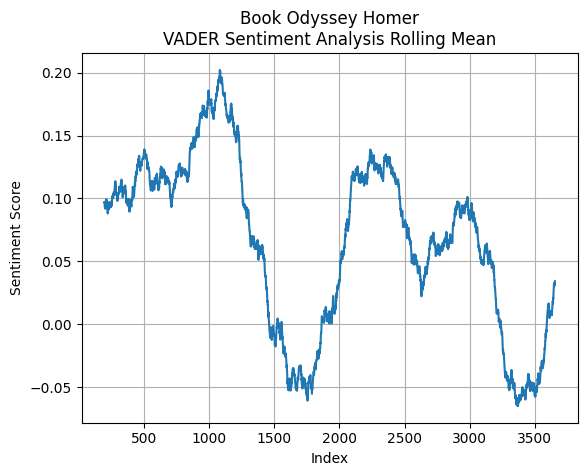

In [45]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = vader_df['vader'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nVADER Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_vader')

plt.show()

# Close the plot to free up memory
plt.close()

#### **[STOP to GRANT PERMISSION]** Pop-up dialog box asks permission to download files

In [46]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [47]:
# Call the function to save the DataFrame to CSV
save_df2csv_and_download(vader_df, '_vader_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)

STEP 1. Saving DataFrame to temporary VM CSV file: data_odyssey_homer_vader_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_odyssey_homer_vader_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

### TextBlob

In [49]:
from textblob import TextBlob

In [50]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [51]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [52]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['textblob'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,textblob
0,0,"tell me, muse, of that man, so ready at need, ...",0.325
1,1,"nay, but even so he saved not his company, tho...",0.000
2,2,for through the blindness of their own hearts ...,0.600
3,3,"of these things, goddess, daughter of zeus, wh...",0.000
4,4,"now all the rest, as many as fled from sheer d...",0.220


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Odyssey Homer\nTextBlob Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_odyssey_homer_textblob_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_odyssey_homer_textblob_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

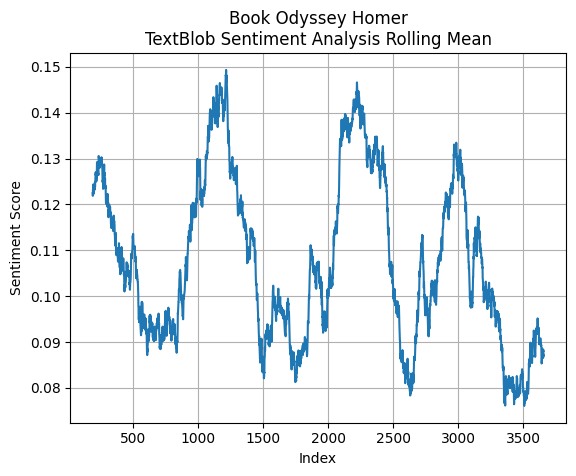

In [53]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = textblob_df['textblob'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nTextBlob Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_textblob')

plt.show()

# Close the plot to free up memory
plt.close()


In [54]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [55]:
###CODE_5:
# Save TextBlob Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(textblob_df, '_textblob_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)

STEP 1. Saving DataFrame to temporary VM CSV file: data_odyssey_homer_textblob_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_odyssey_homer_textblob_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

## STEP (2): Connectionist: Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

### Transformer Setup

In [57]:
!pip install -q transformers

In [58]:
!pip install sentencepiece

In [59]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

In [60]:
from transformers import TrainingArguments

In [61]:
# Test Dataset: List of TestSentiment Strings

test_lines_ls = [
    "I love you.",
    "You hate me.",
    "I'm not sure if I hate you, but I certainly don't care for your attitude young man!"
]

In [62]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### HF: DistilBERT Finetuned (sst2en)

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

**[STOP to GRANT PERMISSION]** to HF_TOKEN

In "Secrets" configure "Notebook Access" for HF_TOKEN or else a pop-up dialog box will STOP here and manually request permissions

In [63]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [64]:
# Create training arguments to disable wandb monitoring

training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [65]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [66]:
# import wandb

# wandb.init() # wandb.log()

In [67]:
%%time

# NOTE: Must click on output LINK, get wandb API_KEY, and paste it in text input box

# NOTE: 0m40s 02:49EST on 28Oct2022 Colab Pro (The Idiot)


# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 21.1 s, sys: 289 ms, total: 21.3 s
Wall time: 30.9 s


In [68]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [69]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [70]:
line_no_ls = list(range(len(sentiment_ls)))

In [71]:
# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','distilbert','label','score'])
distilbert_df.head()

,line_no,line,distilbert,label,score
0,0,"tell me, muse, of that man, so ready at need, ...",1,POSITIVE,0.995655
1,1,"nay, but even so he saved not his company, tho...",0,NEGATIVE,0.998231
2,2,for through the blindness of their own hearts ...,0,NEGATIVE,0.963024
3,3,"of these things, goddess, daughter of zeus, wh...",1,POSITIVE,0.689761
4,4,"now all the rest, as many as fled from sheer d...",0,NEGATIVE,0.896342


In [72]:
distilbert_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Odyssey Homer\nDistilBERT Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_odyssey_homer_distilbert_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_odyssey_homer_distilbert_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

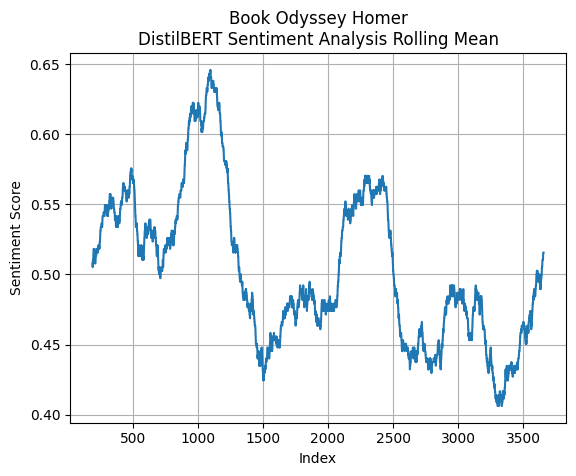

In [73]:
# Plot VADER

win_per = 0.1
win_size = int(win_per * distilbert_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'distilbert' sentiment column
_ = distilbert_df['distilbert'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nDistilBERT Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_distilbert')

plt.show()

# Close the plot to free up memory
plt.close()


In [74]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [75]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(distilbert_df, '_distilbert_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_odyssey_homer_distilbert_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_odyssey_homer_distilbert_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [77]:
# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [78]:
# Tokenize texts and create prediction data set

# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [79]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [80]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [81]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)
#        1m27s 02:42EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 1min 2s, sys: 342 ms, total: 1min 2s
Wall time: 1min 3s


In [82]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [83]:
line_no_ls = list(range(len(sentiment_ls)))

In [84]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','nlptown','label','score'])
nlptown_df.head()

,line_no,line,nlptown,label,score
0,0,"tell me, muse, of that man, so ready at need, ...",4,5 stars,0.693498
1,1,"nay, but even so he saved not his company, tho...",1,2 stars,0.471363
2,2,for through the blindness of their own hearts ...,0,1 star,0.392356
3,3,"of these things, goddess, daughter of zeus, wh...",4,5 stars,0.421389
4,4,"now all the rest, as many as fled from sheer d...",4,5 stars,0.267875


In [85]:
nlptown_df.shape

(3848, 5)

In [86]:
nlptown_df['label'].unique()

array(['5 stars', '2 stars', '1 star', '4 stars', '3 stars'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Odyssey Homer\nNLPTown Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_odyssey_homer_nlptown_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_odyssey_homer_nlptown_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

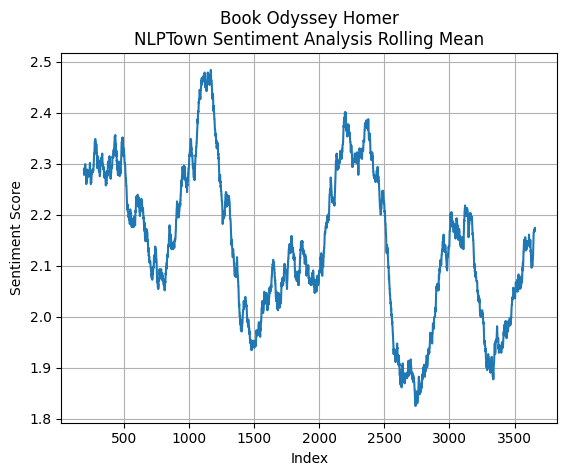

In [87]:
###CODE_7:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'nlptown' sentiment column
_ = nlptown_df['nlptown'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nNLPTown Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_nlptown')

plt.show()

# Close the plot to free up memory
plt.close()

In [88]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(5)

In [89]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(nlptown_df, '_nlptown_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_odyssey_homer_nlptown_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_odyssey_homer_nlptown_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

### HF: RoBERTa Finetuned (en)

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [91]:
# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [92]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [93]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [94]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 2min 48s, sys: 491 ms, total: 2min 49s
Wall time: 3min 1s


In [95]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [96]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [97]:
line_no_ls = list(range(len(sentiment_ls)))

In [98]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

,line_no,line,roberta15lg,label,score
0,0,"tell me, muse, of that man, so ready at need, ...",1,POSITIVE,0.995812
1,1,"nay, but even so he saved not his company, tho...",0,NEGATIVE,0.989767
2,2,for through the blindness of their own hearts ...,0,NEGATIVE,0.988840
3,3,"of these things, goddess, daughter of zeus, wh...",1,POSITIVE,0.987400
4,4,"now all the rest, as many as fled from sheer d...",1,POSITIVE,0.991539


In [99]:
roberta15lg_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Odyssey Homer\nRoBERTa Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_odyssey_homer_roberta15lg_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_odyssey_homer_roberta15lg_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

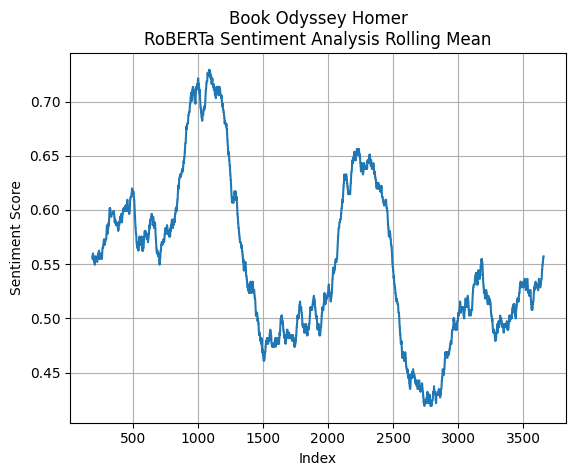

In [100]:
# Plot

win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'roberta15lg' sentiment column
_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nRoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_roberta15lg')

plt.show()

# Close the plot to free up memory
plt.close()


In [101]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [102]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(roberta15lg_df, '_roberta15lg_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_odyssey_homer_roberta15lg_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_odyssey_homer_roberta15lg_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

# Plot

## Dialate SentimentR, Combine, and Plot Together

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [104]:
def make_csv_list(filename_root):
    # List of possible model names
    model_ls = ['vader', 'textblob', 'syuzhetr', 'sentimentr', 'distilbert', 'nlptown', 'roberta15lg']

    # Remove the file extension and extract the title_author part
    filename_without_ext = os.path.splitext(filename_root)[0]
    parts = filename_without_ext.split('_')
    title_author = '_'.join(parts[1:3])  # Get both parts of title_author (e.g., "dracula_bramstoker")

    # Initialize an empty list to hold the found CSV files
    csv_list = []

    # Debugging information
    print(f"Looking for files with title_author: {title_author}")

    # Iterate through each model name and construct the expected filename
    for model_name in model_ls:
        # Construct the filename based on the new pattern
        csv_filename = f'data_{title_author}_{model_name}_sentiment.csv'

        # Check if the file exists in the current directory
        if os.path.isfile(csv_filename):
            csv_list.append(csv_filename)
        else:
            print(f"File not found: {csv_filename}")

    return csv_list


In [105]:
# sentiment_all_df.

In [106]:
# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)

# BOOK_FILENAME_AUTHOR_CLEAN = 'book_jane-eyre_cbronte'
# BOOK_FILENAME_AUTHOR_CLEAN = novel_name_str
BOOK_FILENAME_AUTHOR_CLEAN

'book_odyssey_homer'

In [107]:
!ls -altr

total 4968
drwxr-xr-x 4 root root   4096 Nov 20 14:25 .config
drwxr-xr-x 1 root root   4096 Nov 20 14:26 sample_data
drwxr-xr-x 1 root root   4096 Nov 21 22:32 ..
-rw-r--r-- 1 root root     12 Nov 21 22:36 test.txt
-rw-r--r-- 1 root root 639541 Nov 21 22:37 book_odyssey_homer.txt
-rw-r--r-- 1 root root 621921 Nov 21 22:37 book_odyssey_homer_segments.txt
-rw-r--r-- 1 root root  43814 Nov 21 22:38 plot_odyssey_homer_vader_sentiment.png
-rw-r--r-- 1 root root 673974 Nov 21 22:38 data_odyssey_homer_vader_sentiment.csv
-rw-r--r-- 1 root root  52949 Nov 21 22:38 plot_odyssey_homer_textblob_sentiment.png
-rw-r--r-- 1 root root 687076 Nov 21 22:38 data_odyssey_homer_textblob_sentiment.csv
drwxr-xr-x 2 root root   4096 Nov 21 22:39 results
-rw-r--r-- 1 root root  44466 Nov 21 22:39 plot_odyssey_homer_distilbert_sentiment.png
-rw-r--r-- 1 root root 730816 Nov 21 22:39 data_odyssey_homer_distilbert_sentiment.csv
-rw-r--r-- 1 root root  48416 Nov 21 22:41 plot_odyssey_homer_nlptown_sentiment.png
-

In [108]:
'''
import os
import re
from pathlib import Path

def remove_file_ver(directory="."):
    """
    Renames versioned files in the specified directory:
    1. Identifies the highest version number `n` for files with " (n)" in the filename.
    2. Renames all original files without a version to include " (n+1)".
    3. Removes the highest version " (n)" from filenames to restore them to the original format.

    Parameters:
    directory (str): Path to the directory to process. Defaults to the current directory.
    """
    dir_path = Path(directory)

    # Regular expression to capture versioned files (e.g., filename (1).csv)
    versioned_pattern = re.compile(r"^(.*) \((\d+)\)\.(.+)$")

    # Dictionary to store file roots and their maximum version number
    file_versions = {}
    unversioned_files = []

    # Identify files and their versions
    for file in dir_path.iterdir():
        match = versioned_pattern.match(file.name)
        if match:
            file_root, version, extension = match.groups()
            version = int(version)
            if (file_root, extension) not in file_versions:
                file_versions[(file_root, extension)] = version
            else:
                file_versions[(file_root, extension)] = max(file_versions[(file_root, extension)], version)
        else:
            # Check if it's a valid unversioned file
            if file.is_file():
                file_stem, file_extension = file.stem, file.suffix[1:]
                unversioned_files.append((file_stem, file_extension))

    # Step 2: Rename unversioned files to " (n+1)"
    for file_root, extension in unversioned_files:
        if (file_root, extension) in file_versions:
            new_version = file_versions[(file_root, extension)] + 1
        else:
            new_version = 1

        old_path = dir_path / f"{file_root}.{extension}"
        new_path = dir_path / f"{file_root} ({new_version}).{extension}"
        if old_path.exists():
            os.rename(old_path, new_path)
            print(f"Renamed: {old_path} -> {new_path}")

        # Update file_versions with the new version
        file_versions[(file_root, extension)] = new_version

    # Step 3: Rename highest version files to original names
    for (file_root, extension), highest_version in file_versions.items():
        versioned_path = dir_path / f"{file_root} ({highest_version}).{extension}"
        original_path = dir_path / f"{file_root}.{extension}"
        if versioned_path.exists():
            os.rename(versioned_path, original_path)
            print(f"Renamed: {versioned_path} -> {original_path}")
''';

In [109]:
# remove_file_ver(directory=".")
# !ls -altr

In [110]:
!ls -altr

total 4968
drwxr-xr-x 4 root root   4096 Nov 20 14:25 .config
drwxr-xr-x 1 root root   4096 Nov 20 14:26 sample_data
drwxr-xr-x 1 root root   4096 Nov 21 22:32 ..
-rw-r--r-- 1 root root     12 Nov 21 22:36 test.txt
-rw-r--r-- 1 root root 639541 Nov 21 22:37 book_odyssey_homer.txt
-rw-r--r-- 1 root root 621921 Nov 21 22:37 book_odyssey_homer_segments.txt
-rw-r--r-- 1 root root  43814 Nov 21 22:38 plot_odyssey_homer_vader_sentiment.png
-rw-r--r-- 1 root root 673974 Nov 21 22:38 data_odyssey_homer_vader_sentiment.csv
-rw-r--r-- 1 root root  52949 Nov 21 22:38 plot_odyssey_homer_textblob_sentiment.png
-rw-r--r-- 1 root root 687076 Nov 21 22:38 data_odyssey_homer_textblob_sentiment.csv
drwxr-xr-x 2 root root   4096 Nov 21 22:39 results
-rw-r--r-- 1 root root  44466 Nov 21 22:39 plot_odyssey_homer_distilbert_sentiment.png
-rw-r--r-- 1 root root 730816 Nov 21 22:39 data_odyssey_homer_distilbert_sentiment.csv
-rw-r--r-- 1 root root  48416 Nov 21 22:41 plot_odyssey_homer_nlptown_sentiment.png
-

In [111]:
# Example usage
csv_list = make_csv_list(BOOK_FILENAME_AUTHOR_CLEAN)
print(csv_list)

Looking for files with title_author: odyssey_homer
File not found: data_odyssey_homer_syuzhetr_sentiment.csv
File not found: data_odyssey_homer_sentimentr_sentiment.csv
['data_odyssey_homer_vader_sentiment.csv', 'data_odyssey_homer_textblob_sentiment.csv', 'data_odyssey_homer_distilbert_sentiment.csv', 'data_odyssey_homer_nlptown_sentiment.csv', 'data_odyssey_homer_roberta15lg_sentiment.csv']


In [112]:
models_sa_ls = make_csv_list(BOOK_FILENAME_AUTHOR_CLEAN)
for amodel in models_sa_ls:
  print(amodel)

Looking for files with title_author: odyssey_homer
File not found: data_odyssey_homer_syuzhetr_sentiment.csv
File not found: data_odyssey_homer_sentimentr_sentiment.csv
data_odyssey_homer_vader_sentiment.csv
data_odyssey_homer_textblob_sentiment.csv
data_odyssey_homer_distilbert_sentiment.csv
data_odyssey_homer_nlptown_sentiment.csv
data_odyssey_homer_roberta15lg_sentiment.csv


In [113]:
# models_sa_ls.remove('book_the-great-gatsby_fscottfitzgerald_sentimentr.csv')

In [114]:
for amodel in models_sa_ls:
  print(f"\n\n{amodel}")
  temp_df = pd.read_csv(amodel)
  print(temp_df.columns)



data_odyssey_homer_vader_sentiment.csv
Index(['line_no', 'line', 'vader'], dtype='object')


data_odyssey_homer_textblob_sentiment.csv
Index(['line_no', 'line', 'textblob'], dtype='object')


data_odyssey_homer_distilbert_sentiment.csv
Index(['line_no', 'line', 'distilbert', 'label', 'score'], dtype='object')


data_odyssey_homer_nlptown_sentiment.csv
Index(['line_no', 'line', 'nlptown', 'label', 'score'], dtype='object')


data_odyssey_homer_roberta15lg_sentiment.csv
Index(['line_no', 'line', 'roberta15lg', 'label', 'score'], dtype='object')


In [115]:
len(models_sa_ls)

5

In [116]:
sentiment_all_df = pd.read_csv(models_sa_ls[0])  # Start with vader

for i, amodel in enumerate(models_sa_ls[1:]):
    model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
    print(f'Model #{i}: {model_name_str}')

    one_model_df = pd.read_csv(amodel)
    print(f' Cols: {one_model_df.columns.to_list()}')

    # Special handling for sentimentr which has different structure
    if 'sentimentr' in model_name_str:
        # Add line_no as index+1 since sentimentr is missing it
        one_model_df['line_no'] = range(1, len(one_model_df) + 1)

    # Remove unnecessary columns
    cols_to_drop = ['line', 'label', 'score']
    for col in cols_to_drop:
        if col in one_model_df.columns:
            one_model_df.drop(columns=[col], inplace=True)

    # Rename sentiment column if it exists
    if 'sentiment' in one_model_df.columns:
        one_model_df.rename(columns={'sentiment': model_name_str}, inplace=True)

    # Merge on line_no
    sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

Model #0: sentiment
 Cols: ['line_no', 'line', 'textblob']
Model #1: sentiment
 Cols: ['line_no', 'line', 'distilbert', 'label', 'score']
Model #2: sentiment
 Cols: ['line_no', 'line', 'nlptown', 'label', 'score']
Model #3: sentiment
 Cols: ['line_no', 'line', 'roberta15lg', 'label', 'score']


In [117]:
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3848 non-null   int64  
 1   line         3848 non-null   object 
 2   vader        3848 non-null   float64
 3   textblob     3848 non-null   float64
 4   distilbert   3848 non-null   int64  
 5   nlptown      3848 non-null   int64  
 6   roberta15lg  3848 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 210.6+ KB


In [118]:
# prompt: for sentiment_all_df columns rename sentiment_x and sentiment_y to vader and textblob

sentiment_all_df.rename(columns={'sentiment_x': 'vader', 'sentiment_y': 'textblob'}, inplace=True)
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3848 non-null   int64  
 1   line         3848 non-null   object 
 2   vader        3848 non-null   float64
 3   textblob     3848 non-null   float64
 4   distilbert   3848 non-null   int64  
 5   nlptown      3848 non-null   int64  
 6   roberta15lg  3848 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 210.6+ KB


In [119]:
'''
# prompt: on the same plot, first z-score normalize and then plot the sma (10% window) of vader, textblob, distilbert, nlptown, roberta15lg together

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming sentiment_all_df is your DataFrame containing sentiment scores for different models
# and it has columns 'vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg'

# Z-score normalize the sentiment scores
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
  sentiment_all_df[col] = zscore(sentiment_all_df[col])

# Calculate the SMA (Simple Moving Average) with a 10% window for each model
win_per = 0.1
win_size = int(win_per * sentiment_all_df.shape[0])
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
  sentiment_all_df[f'{col}_sma'] = sentiment_all_df[col].rolling(win_size, center=True).mean()

# Plot the SMA of each model on the same plot
plt.figure(figsize=(12, 6))
for col in ['vader_sma', 'textblob_sma', 'distilbert_sma', 'nlptown_sma', 'roberta15lg_sma']:
  plt.plot(sentiment_all_df[col], label=col.replace('_sma', ''))

plt.title(f'{BOOK_TITLE_AUTHOR_CLEAN}\n SMA of Z-score Normalized Sentiment Scores')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_all')

plt.show()
''';

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'book_odyssey_homer\nSMA of Z-score Normalized Sentiment Scores')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_odyssey_homer_sma_all_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_odyssey_homer_sma_all_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

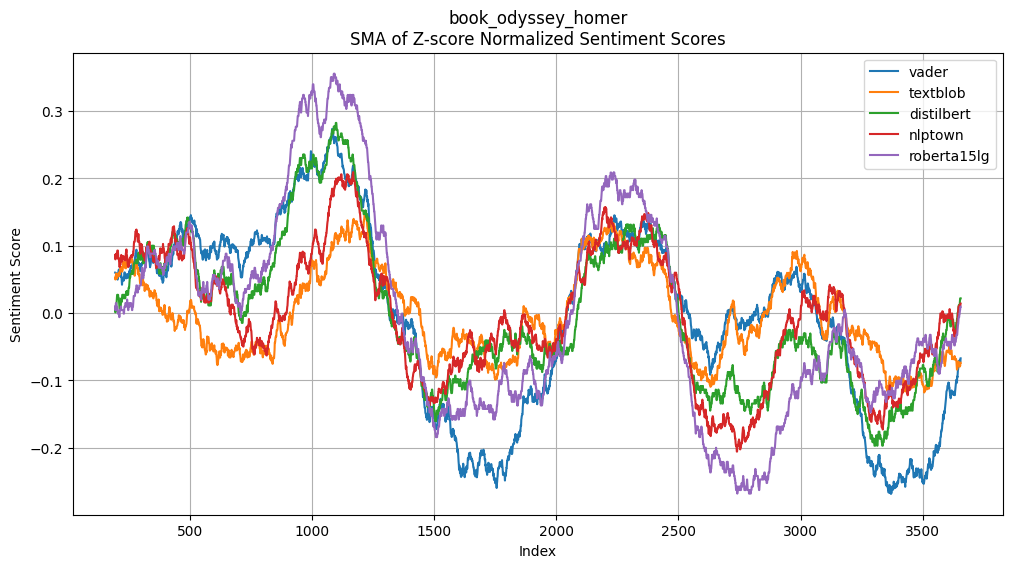

In [120]:
# Assuming sentiment_all_df is your DataFrame containing sentiment scores for different models
# and it has columns 'vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg'

# Z-score normalize the sentiment scores
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
    sentiment_all_df[col] = zscore(sentiment_all_df[col])

# Calculate the SMA (Simple Moving Average) with a 10% window for each model
win_per = 0.1
win_size = int(win_per * sentiment_all_df.shape[0])
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
    sentiment_all_df[f'{col}_sma'] = sentiment_all_df[col].rolling(win_size, center=True).mean()

# Plot the SMA of each model on the same plot
plt.figure(figsize=(12, 6))
for col in ['vader_sma', 'textblob_sma', 'distilbert_sma', 'nlptown_sma', 'roberta15lg_sma']:
    plt.plot(sentiment_all_df[col], label=col.replace('_sma', ''))

plt.title(f'{BOOK_TITLE_AUTHOR_CLEAN}\nSMA of Z-score Normalized Sentiment Scores')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)

# Save the plot to a PNG file
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_sma_all')

plt.show()



In [121]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

STEP 1. Saving plot to temporary VM file: plot_odyssey_homer_correlation_heatmap_sma_all_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_odyssey_homer_correlation_heatmap_sma_all_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

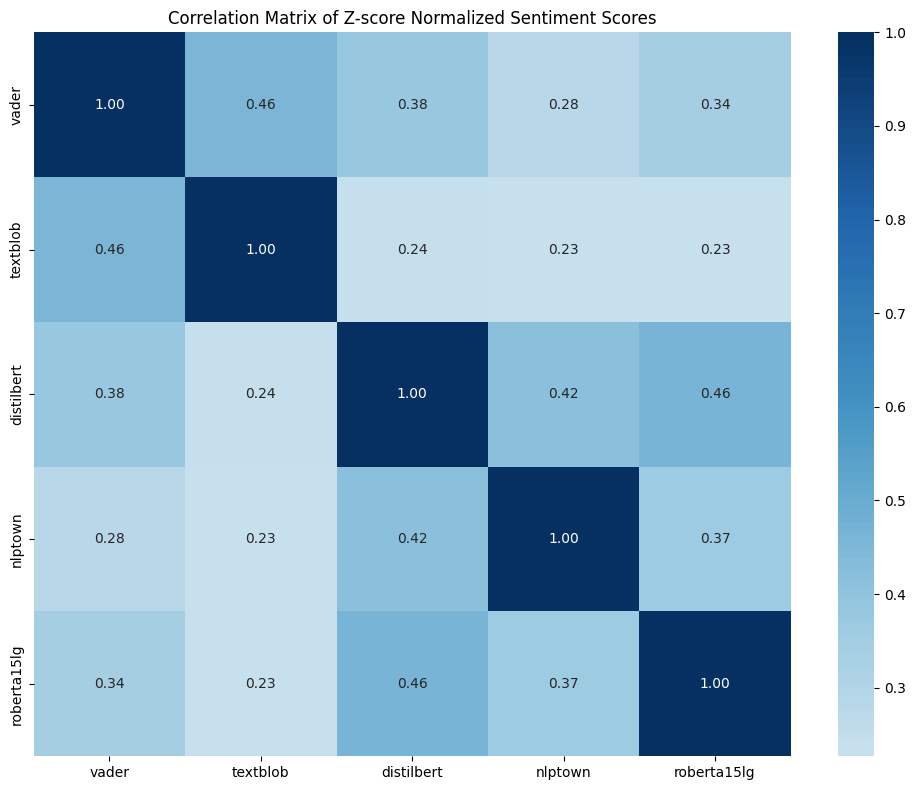

In [122]:
# Define the function to plot the correlation heatmap
def plot_correlation_heatmap(df, columns, title="Correlation Matrix of Sentiment Scores", save_filename=""):
    """
    Plot a correlation heatmap for specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing sentiment scores.
    - columns (list): List of columns to calculate correlations for.
    - title (str): Title for the heatmap plot.
    - save_filename (str): Optional filename to save the plot.
    """
    correlation_matrix = df[columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
    plt.title(title)
    plt.tight_layout()

    if save_filename:
        save_plot2png('_sentiment.png', nodate=True, base_filename=f'{save_filename}_sma_all')

    plt.show()

# Call plot_correlation_heatmap with the z-score normalized columns
plot_correlation_heatmap(
    sentiment_all_df,
    columns=['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg'],
    title="Correlation Matrix of Z-score Normalized Sentiment Scores",
    save_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_correlation_heatmap'
)


In [123]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [124]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(roberta15lg_df, '_sma_all_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_odyssey_homer_sma_all_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_odyssey_homer_sma_all_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [125]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [126]:
'''
def plot_all(sentiment_all_df):
   """
   Plot all sentiment columns after z-score normalization, using SMA smoothing.
   Window size is 10% of series length, with 5% edge extrapolation.
   Includes mean of all series in black.

   Parameters:
   sentiment_all_df (pd.DataFrame): DataFrame containing sentiment columns and line_no
   """
   import matplotlib.pyplot as plt
   import seaborn as sns
   from scipy import stats
   import numpy as np
   import pandas as pd

   # Create a copy to avoid modifying the original dataframe
   df = sentiment_all_df.copy()

   # Get all columns except line_no
   sentiment_cols = [col for col in df.columns if col != 'line_no']

   # Convert columns to numeric, dropping any that can't be converted
   numeric_cols = []
   for col in sentiment_cols:
       try:
           df[col] = pd.to_numeric(df[col])
           numeric_cols.append(col)
       except (ValueError, TypeError):
           print(f"Warning: Dropping column '{col}' as it contains non-numeric values")
           continue

   if not numeric_cols:
       raise ValueError("No numeric columns found for plotting")

   # Calculate window size (10% of series length)
   window_size = max(3, int(len(df) * 0.1))
   # Calculate extrapolation size (5% of series length)
   extrap_size = int(len(df) * 0.05)

   # Create figure with appropriate size
   plt.figure(figsize=(15, 8))

   # Store smoothed series for calculating mean
   all_smoothed = []
   base_linewidth = 1.5  # Base line width for individual series

   # Plot each sentiment column after z-normalization and smoothing
   for col in numeric_cols:
       # Z-normalize the column
       z_scores = stats.zscore(df[col], nan_policy='omit')

       # Create series for smoothing
       series = pd.Series(z_scores)

       # Extrapolate edges before smoothing
       start_values = series[:extrap_size].values[::-1]
       end_values = series[-extrap_size:].values[::-1]

       # Create extended series
       extended_series = pd.concat([
           pd.Series(start_values),
           series,
           pd.Series(end_values)
       ])

       # Apply SMA
       smoothed = extended_series.rolling(window=window_size, center=True).mean()

       # Trim back to original size
       smoothed = smoothed[extrap_size:-extrap_size]

       # Store smoothed series for mean calculation
       all_smoothed.append(smoothed)

       # Plot with some transparency for better visibility when lines overlap
       plt.plot(df['line_no'], smoothed, label=col, alpha=0.7, linewidth=base_linewidth)

   # Calculate and plot mean of all series
   mean_series = pd.concat(all_smoothed, axis=1).mean(axis=1)
   plt.plot(df['line_no'], mean_series, label='Mean of All', color='black',
            alpha=0.7, linewidth=base_linewidth*2)

   # Customize the plot
   plt.title(f'Z-normalized Sentiment Analysis Comparison\n(SMA window: {window_size} lines, {extrap_size} lines extrapolated at edges)',
             fontsize=14)
   plt.xlabel('Line Number', fontsize=12)
   plt.ylabel('Z-normalized Sentiment Score', fontsize=12)

   # Add legend with smaller font and outside the plot
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
             fontsize=10, borderaxespad=0.)

   # Add grid for better readability
   plt.grid(True, linestyle='--', alpha=0.7)

   # Adjust layout to prevent legend cutoff
   plt.tight_layout()

   # Show the plot
   plt.show()

   # Print basic statistics
   print("\nCorrelation between different sentiment analyses:")
   correlation_matrix = df[numeric_cols].corr()

   # Use seaborn to create a heatmap of correlations
   plt.figure(figsize=(12, 10))
   sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
   plt.title('Correlation Matrix of Sentiment Analyses', fontsize=14)
   plt.tight_layout()
   plt.show()

   # Print mean absolute differences between normalized scores
   print("\nMean absolute differences between normalized scores:")
   z_scores_df = df[numeric_cols].apply(lambda x: stats.zscore(x, nan_policy='omit'))

   for i, col1 in enumerate(numeric_cols):
       for col2 in numeric_cols[i+1:]:
           mad = abs(z_scores_df[col1] - z_scores_df[col2]).mean()
           print(f"{col1} vs {col2}: {mad:.3f}")

   return df[numeric_cols]  # Return the numeric columns for further analysis if needed
   '''

'\ndef plot_all(sentiment_all_df):\n   """\n   Plot all sentiment columns after z-score normalization, using SMA smoothing.\n   Window size is 10% of series length, with 5% edge extrapolation.\n   Includes mean of all series in black.\n\n   Parameters:\n   sentiment_all_df (pd.DataFrame): DataFrame containing sentiment columns and line_no\n   """\n   import matplotlib.pyplot as plt\n   import seaborn as sns\n   from scipy import stats\n   import numpy as np\n   import pandas as pd\n\n   # Create a copy to avoid modifying the original dataframe\n   df = sentiment_all_df.copy()\n\n   # Get all columns except line_no\n   sentiment_cols = [col for col in df.columns if col != \'line_no\']\n\n   # Convert columns to numeric, dropping any that can\'t be converted\n   numeric_cols = []\n   for col in sentiment_cols:\n       try:\n           df[col] = pd.to_numeric(df[col])\n           numeric_cols.append(col)\n       except (ValueError, TypeError):\n           print(f"Warning: Dropping column 

In [127]:
# plot_all(sentiment_all_df)

In [128]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

# Crux Detection and Extraction

## Smooth Plots and Add Crux Points

In [129]:
def get_sentiment_mean(df):
    """Same as before"""
    sentiment_cols = [col for col in df.columns
                     if col not in ['line', 'line_no']]
    return df[sentiment_cols].mean(axis=1).tolist()


def detect_peaks_valleys(smoothed_series, peak_algo='find_peaks', peak_algo_params=None):
    """
    Detect peaks and valleys using specified algorithm.

    Args:
        smoothed_series (list): Smoothed and normalized time series
        peak_algo (str): Peak detection algorithm ('find_peaks', 'relmax', 'threshold')
        peak_algo_params (dict): Parameters for the chosen algorithm

    Returns:
        dict: Dictionary with 'peaks' and 'valleys' indices
    """
    series = np.array(smoothed_series)

    # Default parameters for each algorithm
    default_params = {
        'find_peaks': {
            'distance': 20,
            'prominence': 0.1
        },
        'relmax': {
            'order': 10
        },
        'threshold': {
            'threshold': 0.5,
            'min_dist': 20
        }
    }

    params = peak_algo_params if peak_algo_params is not None else default_params[peak_algo]

    if peak_algo == 'find_peaks':
        peaks, _ = find_peaks(series,
                            distance=params['distance'],
                            prominence=params['prominence'])
        valleys, _ = find_peaks(-series,
                              distance=params['distance'],
                              prominence=params['prominence'])

    elif peak_algo == 'relmax':
        peaks = argrelextrema(series, np.greater,
                            order=params['order'])[0]
        valleys = argrelextrema(series, np.less,
                              order=params['order'])[0]

    elif peak_algo == 'threshold':
        peaks = []
        valleys = []
        min_dist = params['min_dist']
        threshold = params['threshold']

        for i in range(1, len(series)-1):
            if peaks and i - peaks[-1] < min_dist:
                continue
            if valleys and i - valleys[-1] < min_dist:
                continue

            if (series[i] > series[i-1] + threshold and
                series[i] > series[i+1] + threshold):
                peaks.append(i)
            elif (series[i] < series[i-1] - threshold and
                  series[i] < series[i+1] - threshold):
                valleys.append(i)

    else:
        raise ValueError(f"Peak detection algorithm '{peak_algo}' not implemented. "
                        "Use 'find_peaks', 'relmax', or 'threshold'.")

    return {
        'peaks': peaks.tolist() if isinstance(peaks, np.ndarray) else peaks,
        'valleys': valleys.tolist() if isinstance(valleys, np.ndarray) else valleys
    }

def plot_cruxes(book_name, sentiment_mean_ls, sentiment_mean_smooth_ls,
                peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))

    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks with green dashed lines
    y_min, y_max = plt.ylim()
    text_y = y_max + 0.05 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}',
                rotation=90, va='bottom', ha='center')

    # Plot valleys with red dashed lines
    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}',
                rotation=90, va='bottom', ha='center')

    # Customize plot
    plt.title(f'Sentiment Analysis: {book_name}\nPeak Detection: {peak_algo}')
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')

    if SIMPLE:
        plt.legend(['Normalized Sentiment',
                   'Peak Lines', 'Valley Lines'])
    else:
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save plot
    plt.savefig(f'{book_name}_sentiment_plot_{peak_algo}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    return crux_points_dt  # Return detected points for further analysis

def smooth_ts(time_series, method='sma', smooth_param='0.1'):
    """Same as before"""
    series = np.array(time_series)

    if method == 'sma':
        window = max(3, int(float(smooth_param) * len(series)))
        if window % 2 == 0:
            window += 1
        pad_size = window // 2
        padded_series = np.pad(series, (pad_size, pad_size), mode='edge')
        smoothed = np.convolve(padded_series, np.ones(window)/window, mode='valid')

    elif method == 'lowess':
        x = np.arange(len(series))
        smoothed = lowess(
            series,
            x,
            frac=float(smooth_param),
            return_sorted=False
        )
    else:
        raise ValueError(f"Smoothing method '{method}' not implemented. Use 'sma' or 'lowess'.")

    smoothed_min = np.min(smoothed)
    smoothed_max = np.max(smoothed)
    smoothed_normalized = 2 * (smoothed - smoothed_min) / (smoothed_max - smoothed_min) - 1

    return smoothed_normalized.tolist()

In [130]:
def plot_cruxes(model_name, plot_title, sentiment_mean_ls, sentiment_mean_smooth_ls,
                smooth_algo, peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))
    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks and valleys
    y_min, y_max = plt.ylim()
    text_y = y_min + 0.9 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}', rotation=90, va='center', ha='center')

    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}', rotation=90, va='center', ha='center')

    # Customize plot
    # plt.title(f'{BOOK_TITLE_AUTHOR_CLEAN}\nPeak Detection: {peak_algo}')
    plt.title(plot_title)
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save plot before showing it
    plot_filename = f'{PLOT_FILENAME_AUTHOR_CLEAN}_{model_name}_{smooth_algo}_cruxes_{peak_algo}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    # Save the plot to a PNG file with the updated function
    # save_plot2png('_cruxes.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_all')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close()

    # Return detected points for further analysis and the filename
    return crux_points_dt, plot_filename


## Choose Specific Model SentimentArc or Mean of All

In [131]:
# 1. CONFIGURE: Select which model or mean(all) to plot/extract cruxes

# Calculate mean sentiment across all columns

MODEL_INDEX = -1 # set to -1 to use mean of all models

model_ls = ['vader','textblob','distilbert','nlptown','roberta15lg']
if MODEL_INDEX > -1:
  model_name = model_ls[MODEL_INDEX]
  sentiment_mean_ls = sentiment_all_df[model_name].tolist()
else:
  model_name = 'mean'
  sentiment_mean_ls = get_sentiment_mean(sentiment_all_df)


In [132]:
# FUTURE: Use Colab widgets
# print(model_dropdown.value)

In [133]:
print(f"Model: {model_name}")

Model: mean


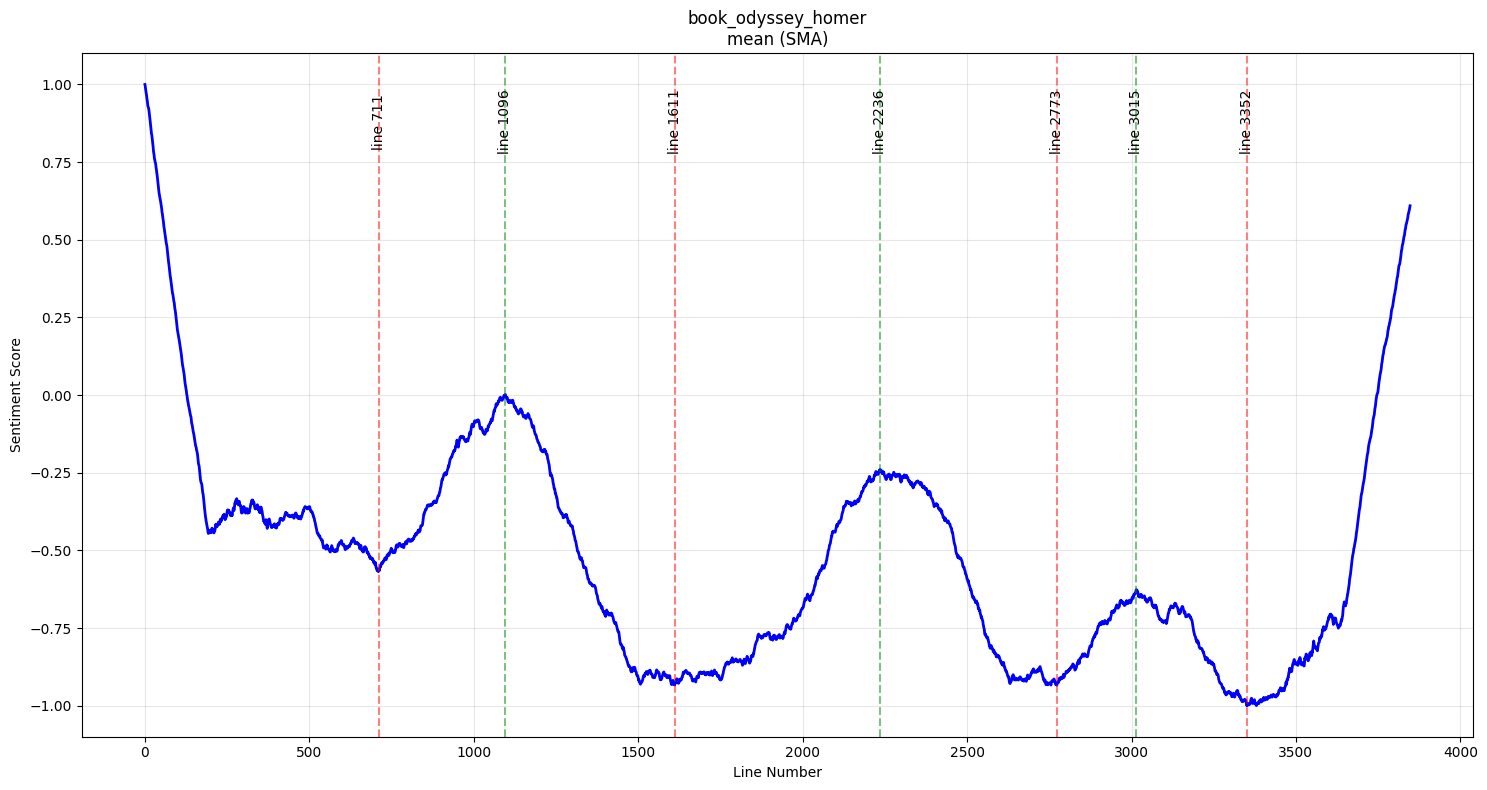

SAVING: book_odyssey_homer
mean (SMA)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [134]:
# 2. Create both SMA and LOWESS smoothed versions
smoothed_sma = smooth_ts(sentiment_mean_ls, method='sma', smooth_param=0.1)
smoothed_lowess = smooth_ts(sentiment_mean_ls, method='lowess', smooth_param=0.1)

# 3. Set up peak detection parameters
peak_params = {
    'distance': 30,
    'prominence': 0.15
}

# 4a. Generate and save SMA plot
crux_points_sma, sma_plot_filename = plot_cruxes(
    model_name,
    BOOK_TITLE_AUTHOR_CLEAN + "\n" + model_name + " (SMA)",
    sentiment_mean_ls,
    smoothed_sma,
    smooth_algo='sma',
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

print("SAVING: " + BOOK_TITLE_AUTHOR_CLEAN + "\n" + model_name + " (SMA)")
# Download SMA plot
files.download(sma_plot_filename)


In [135]:
smooth_algo='sma'
peak_algo='find_peaks'

print(f'{PLOT_FILENAME_AUTHOR_CLEAN}_{model_name}_{smooth_algo}_cruxes_{peak_algo}.png')

plot_odyssey_homer_mean_sma_cruxes_find_peaks.png


In [136]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

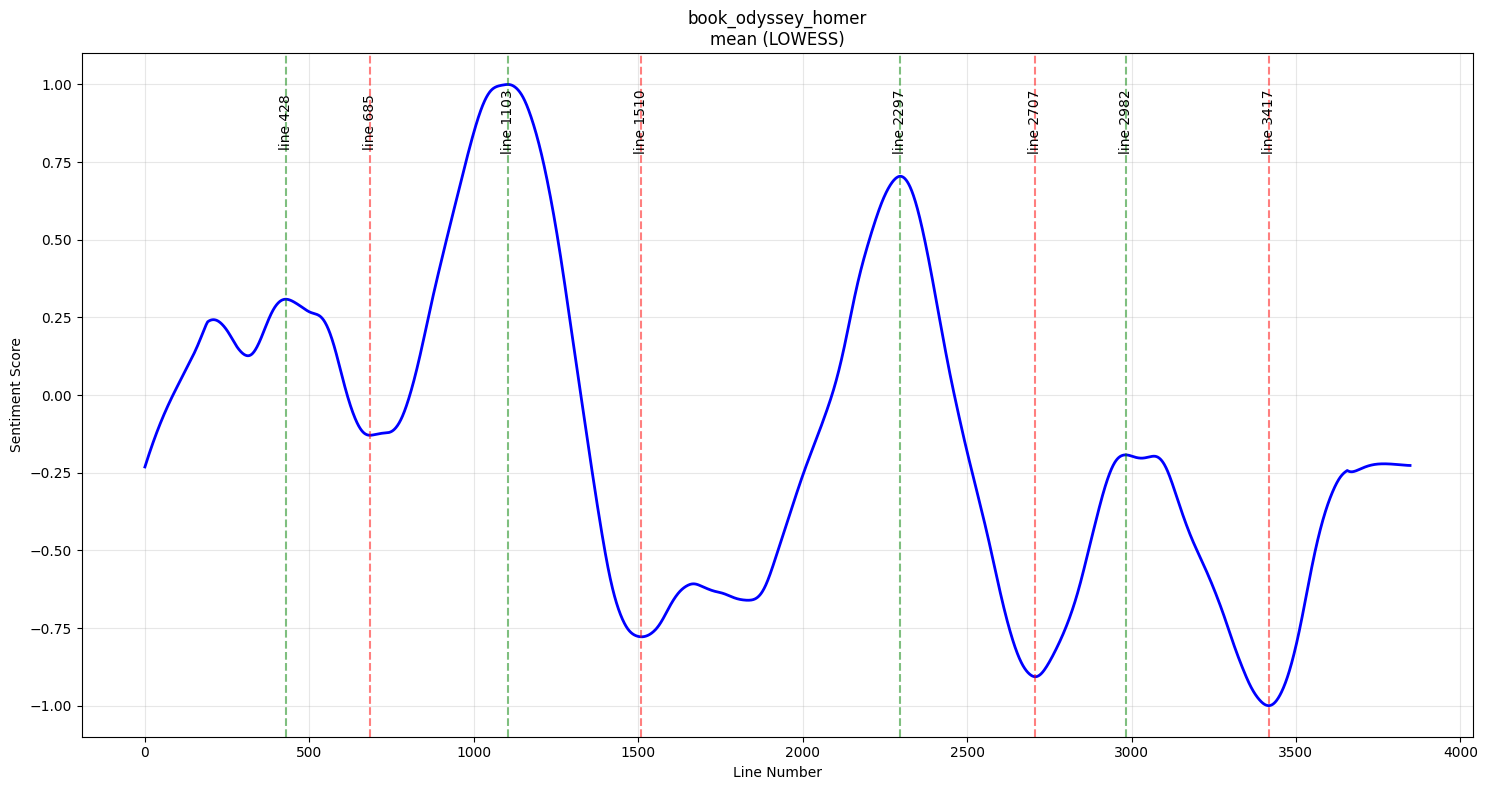

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
# 4b. Generate and save LOWESS plot
crux_points_lowess, lowess_plot_filename = plot_cruxes(
    model_name,
    BOOK_TITLE_AUTHOR_CLEAN + "\n" + model_name + " (LOWESS)",
    sentiment_mean_ls,
    smoothed_lowess,
    smooth_algo='lowess',
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

# Download LOWESS plot
files.download(lowess_plot_filename)

In [138]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

## Generate Crux Reports

In [139]:
# CONFIGURE: Default length of context Window around center Crux Sentence (# sentences incl. center crux sentence)

CONTEXT_WIN_DEFAULT = 11

In [140]:
def get_crux_text(df, smoothed_series, peak_algo='find_peaks', peak_algo_params=None, context_win=CONTEXT_WIN_DEFAULT):
    """
    Extract text surrounding crux points with sentiment values. Center line is uppercased.

    Args:
        df (pd.DataFrame): Input dataframe
        smoothed_series (list): Smoothed time series
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
        context_win (int): Window size for text extraction (odd number)

    Returns:
        tuple: Dictionaries for peaks and valleys text with sentiment
    """
    # Use detect_peaks_valleys instead of get_crux_points
    crux_points_dt = detect_peaks_valleys(smoothed_series, peak_algo, peak_algo_params)

    half_win = context_win // 2
    peaks_dict = {}
    valleys_dict = {}

    def extract_window_text(center_idx, sentiment_val):
        start_idx = max(0, center_idx - half_win)
        end_idx = min(len(df), center_idx + half_win + 1)

        text_lines = df['line'].iloc[start_idx:end_idx].tolist()
        center_relative_idx = center_idx - start_idx
        if 0 <= center_relative_idx < len(text_lines):
            text_lines[center_relative_idx] = text_lines[center_relative_idx].upper()

        return [sentiment_val, text_lines]

    for peak in crux_points_dt['peaks']:
        sentiment_val = smoothed_series[peak]
        peaks_dict[peak] = extract_window_text(peak, sentiment_val)

    for valley in crux_points_dt['valleys']:
        sentiment_val = smoothed_series[valley]
        valleys_dict[valley] = extract_window_text(valley, sentiment_val)

    return peaks_dict, valleys_dict

In [141]:
def make_crux_report(book_name, smoothed_series, df, peak_algo='find_peaks', peak_algo_params=None):
    """
    Generate and save formatted report of crux points analysis.
    Uses fixed window size of 21 lines and highlights crux point lines.

    Args:
        book_name (str): Name of the book being analyzed
        smoothed_series (list): Smoothed time series
        df (pd.DataFrame): Input dataframe with text
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
    """
    crux_peaks_text_dt, crux_valleys_text_dt = get_crux_text(
        df, smoothed_series, peak_algo, peak_algo_params, context_win=21
    )

    # Prepare a sorted list of all crux points with labels
    crux_summary = []
    for line_no, (sentiment, text) in crux_peaks_text_dt.items():
        crux_summary.append((line_no, sentiment, "Peak"))
    for line_no, (sentiment, text) in crux_valleys_text_dt.items():
        crux_summary.append((line_no, sentiment, "Valley"))
    crux_summary.sort(key=lambda x: x[0])  # Sort by line number

    report = []

    # Add summary of all crux points at the top
    report.append(f"Sentiment Analysis Crux Points Report for: {book_name}")
    report.append(f"Peak Detection Algorithm: {peak_algo}")
    report.append("Window Size: 21 lines (10 before, CRUX LINE, 10 after)")
    report.append("=" * 80)
    report.append("SUMMARY OF CRUX POINTS")
    report.append("-" * 40)
    for line_no, sentiment, label in crux_summary:
        report.append(f"{label} at line {line_no} (Sentiment: {sentiment:.3f})")
    report.append("=" * 80 + "\n")

    # Add details for Peaks
    report.append("EMOTIONAL PEAKS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_peaks_text_dt.items()):
        report.append(f"\nPeak at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    # Add details for Valleys
    report.append("\nEMOTIONAL VALLEYS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_valleys_text_dt.items()):
        report.append(f"\nValley at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    # Join all report lines into a single string and save to a file
    report_text = "\n".join(report)
    report_filename = f"{book_name}_crux_report_{peak_algo}.txt"
    with open(report_filename, "w", encoding="utf-8") as f:
        f.write(report_text)

    print(report_text)
    return report_filename  # Return the filename for use in downloading


In [142]:
# 5. Generate reports for both smoothing methods
from google.colab import files

# 5a. SMA report
sma_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR_CLEAN + " " + model_name + "_sma",
    smoothed_sma,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download SMA report
files.download(sma_report_filename)

Sentiment Analysis Crux Points Report for: book_odyssey_homer mean_sma
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)
SUMMARY OF CRUX POINTS
----------------------------------------
Valley at line 711 (Sentiment: -0.568)
Peak at line 1096 (Sentiment: 0.002)
Valley at line 1611 (Sentiment: -0.933)
Peak at line 2236 (Sentiment: -0.240)
Valley at line 2773 (Sentiment: -0.934)
Peak at line 3015 (Sentiment: -0.627)
Valley at line 3352 (Sentiment: -1.000)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 1096 (Sentiment: 0.002)
----------------------------------------
and ulysses answered, "it would be a long story madam, were i to
relate in full the tale of my misfortunes, for the hand of heaven has
been laid heavy upon me; but as regards your question, there is an
island far away in the sea which is called 'the ogygian.'
here dwells the cunning and powerful goddess calypso, daughter of
atlas.
she lives by herself far from a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [143]:
# Delay 3s to allow time for download if [Runtime]->[Run all]

time.sleep(3)

In [144]:
# 5b. LOWESS report
lowess_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR_CLEAN + " " + model_name + "_lowess",
    smoothed_lowess,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download LOWESS report
files.download(lowess_report_filename)


Sentiment Analysis Crux Points Report for: book_odyssey_homer mean_lowess
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)
SUMMARY OF CRUX POINTS
----------------------------------------
Peak at line 428 (Sentiment: 0.309)
Valley at line 685 (Sentiment: -0.129)
Peak at line 1103 (Sentiment: 1.000)
Valley at line 1510 (Sentiment: -0.778)
Peak at line 2297 (Sentiment: 0.704)
Valley at line 2707 (Sentiment: -0.907)
Peak at line 2982 (Sentiment: -0.193)
Valley at line 3417 (Sentiment: -1.000)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 428 (Sentiment: 0.309)
----------------------------------------
presently, when he too could put to sea again, and had sailed on as
far as the malean heads, jove counselled evil against him and made it
blow hard till the waves ran mountains high.
here he divided his fleet and took the one half towards crete where
the cydonians dwell round about the waters of the river iardanus.
there is a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>